## Data pre-processing and basic visualization

In [2]:
pip install statsmodels

     |████████████████████████████████| 9.5MB 9.7MB/s eta 0:00:01     |███████████████████▉            | 5.9MB 9.7MB/s eta 0:00:01
     |████████████████████████████████| 235kB 6.7MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tqdm

     |████████████████████████████████| 71kB 3.5MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.cbook as cbook


from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook


%matplotlib inline

In [2]:
# Import data using datetime and no data value
df = pd.read_csv('tsa_2.csv', index_col=['Date'], parse_dates=['Date'])
df.index = df.index.strftime('%m/%d/%Y')
df.head()

,Attacks
Date,
08/12/2019,30
09/12/2019,62
10/12/2019,57
11/12/2019,49
12/12/2019,109


### Stationarity

Before we start modeling, we should mention such an important property of time series: [**stationarity**](https://en.wikipedia.org/wiki/Stationary_process).

If a process is stationary, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called [homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity))The covariance function does not depend on time; it should only depend on the distance between observations. You can see this visually on the images in the post by [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- The red graph below is not stationary because the mean increases over time.

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- We were unlucky with the variance and see the varying spread of values over time

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Finally, the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice that the spread becomes closer as time increases. Hence, the covariance is not constant with time in the right chart.

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

So why is stationarity so important? Because it is easy to make predictions on a stationary series since we can assume that the future statistical properties will not be different from those currently observed. Most of the time-series models, in one way or the other, try to predict those properties (mean or variance, for example). Furture predictions would be wrong if the original series were not stationary. Unfortunately, most of the time series that we see outside of textbooks are non-stationary, but we can (and should) change this.

So, in order to combat non-stationarity, we have to know our enemy, so to speak. Let's see how we can detect it. We will look at white noise and random walks to learn how to get from one to another for free.

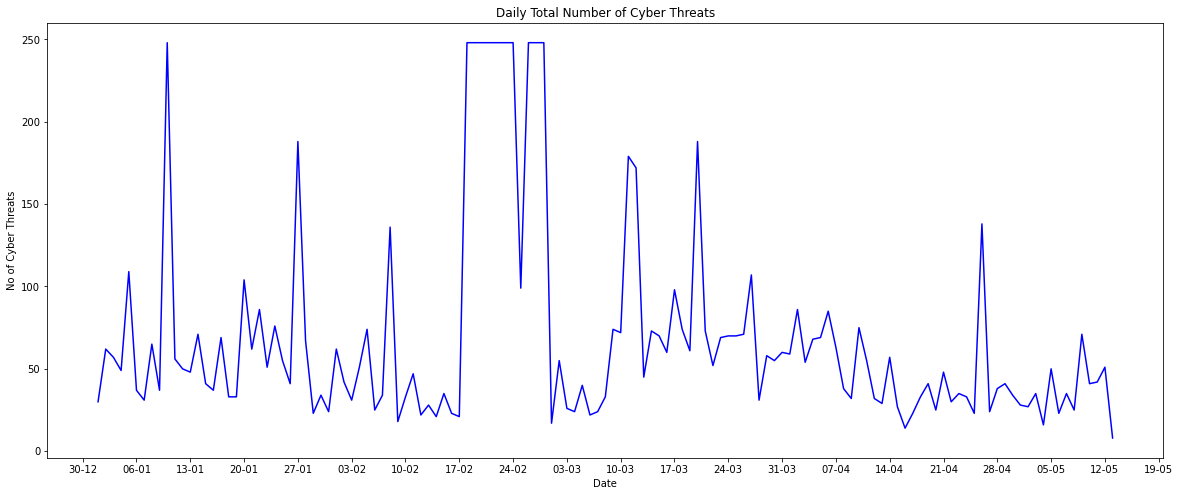

In [3]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(20, 8))

# Add x-axis and y-axis
ax.plot(df.index.values,
       df['Attacks'],
       color='blue')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="No of Cyber Threats",
       title="Daily Total Number of Cyber Threats")

# Define the date format
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

From the basic visualization above, we can roughly check whether the given data is stationary or not
Although in general we can see that the trend is moving up and down, we can still confirm by calculation the **Moving Average**

## Moving Average


We will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the **moving average** and also **rolling mean**.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [4]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df, 1) # prediction for the last observed day (past 1 days)

8.0

So the moving average value of a daily cyber attack case is **38 Attacks**
Therefore we can conclude that the data is not stationary.
We can also plot the movinf average for different window size, as following

In [5]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(15, 6))

    # Add x-axis and y-axis
    ax.plot(df.index.values,
       df['Attacks'])
    
    # Set title and labels for axes
    ax.set(xlabel="Date",
       ylabel="Threats",
       title="Moving average\n window size = {}".format(window))
           
    ax.plot(rolling_mean, "g", label="Rolling mean trend")
    
    # Set title and labels for axes
    ax.set(xlabel="Date",
       ylabel="Threats",
       title="No of Cyber Attacks")

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%d-%m')
    
    # Define the date format
    date_form = DateFormatter("%d-%m")
    ax.xaxis.set_major_formatter(date_form)

    # Ensure a major tick for each week using (interval=1) 
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    
    plt.grid(True)

**Let's smooth by the previous 1 day (Daily).** 

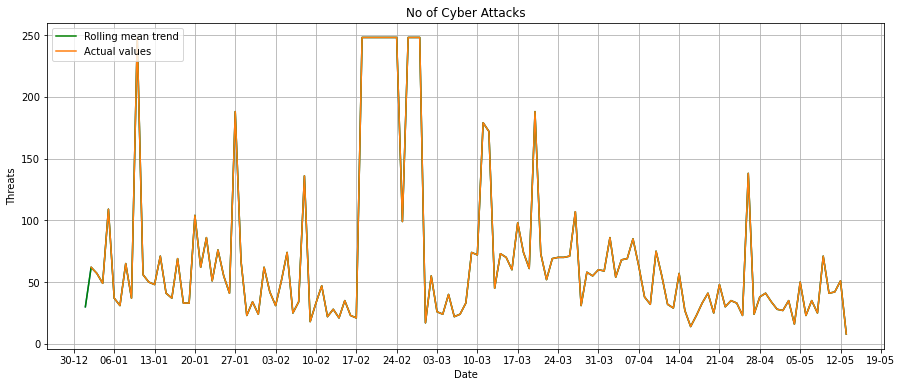

In [6]:
plotMovingAverage(df, 1) 

**Let's smooth by the previous 7 day (Weekly).**

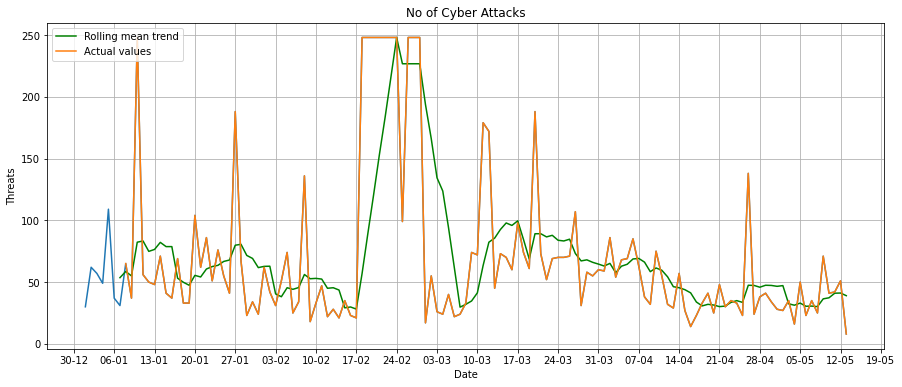

In [7]:
plotMovingAverage(df, 7) 

**Let's smooth by the previous 14 Days (Fortnightly).**

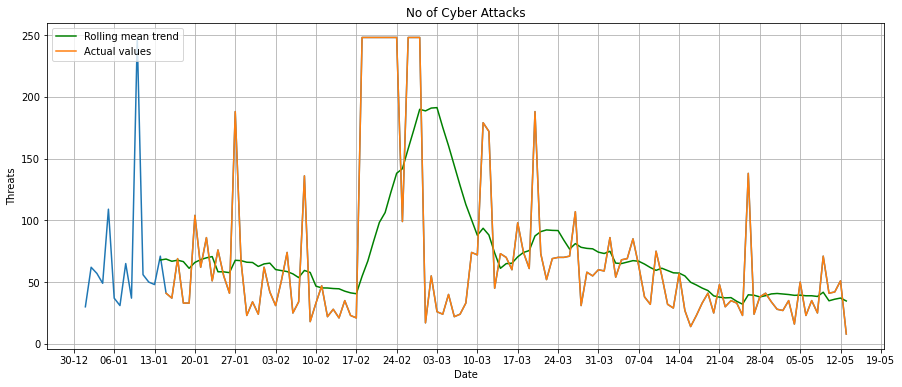

In [8]:
plotMovingAverage(df, 14) 

**Now with the previous 30 days, we get the monthly trend.**

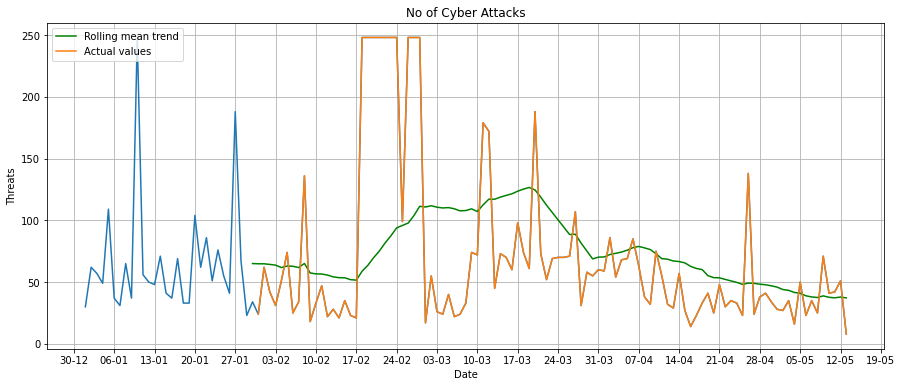

In [9]:
plotMovingAverage(df, 30) 

- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [10]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

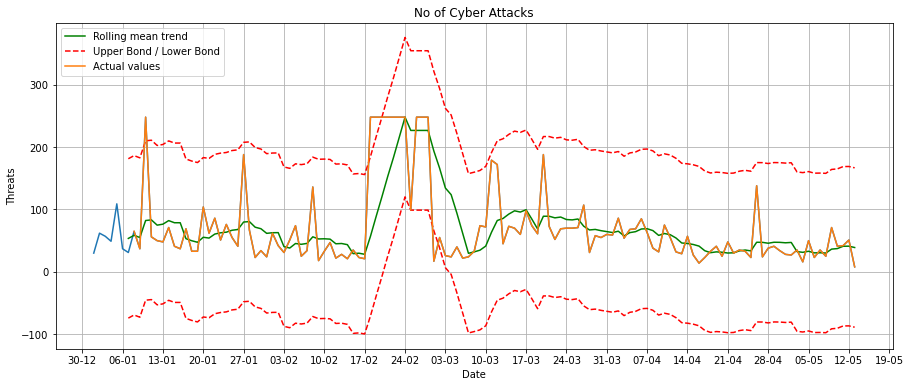

In [11]:
plotMovingAverage(df, 7, plot_intervals=True)

Now, let's create a simple anomaly detection system with the help of moving average.

In [12]:
anomaly = df.copy()
anomaly.iloc[-20] = anomaly.iloc[-20] * 0.2 # say we have 80% drop of attacks 

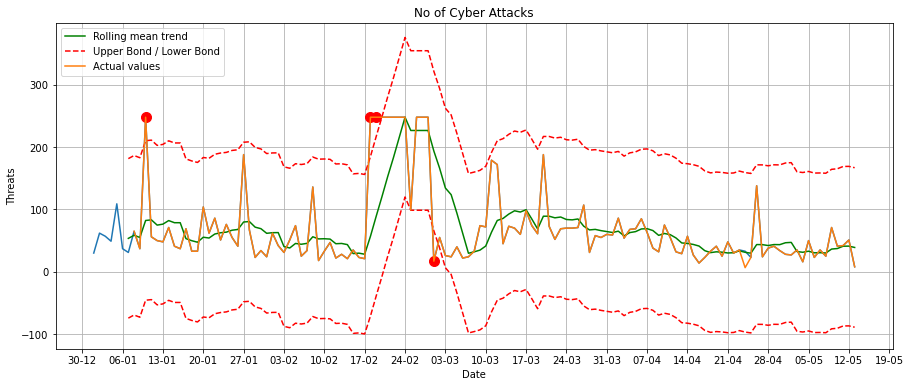

In [13]:
plotMovingAverage(anomaly, 7, plot_intervals=True, plot_anomalies=True) #Window size = 24hours

## Augmented DickyFuller Test

In [18]:
from statsmodels.tsa.stattools import adfuller

print("Results of Dicky Fuller test:")
dftest = adfuller(df['Attacks'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dicky Fuller test:
Test Statistics                 -4.139719
p-value                          0.000832
#Lags Used                       1.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


## Application of Log Scale

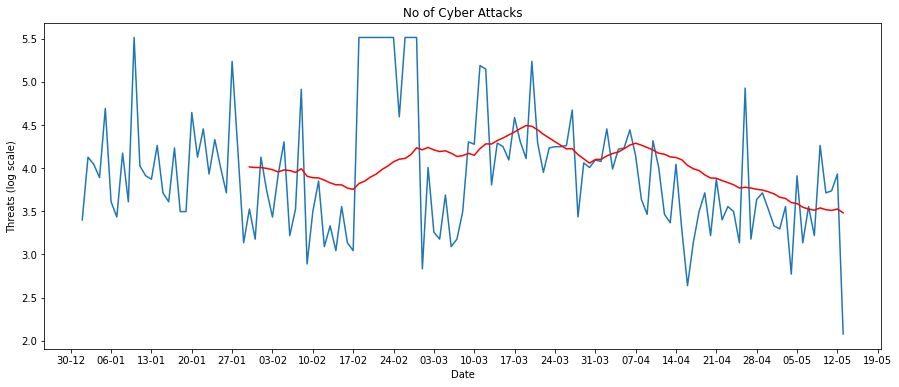

In [39]:
# Use of log scale to visualize the data
df_logscale = np.log(df)
movingAvg = df_logscale.rolling(window=30).mean()

# Create figure and plot space
fig1, ax1 = plt.subplots(figsize=(15, 6))

# Add x-axis and y-axis
ax1.plot(df.index.values,
    df_logscale, 
    movingAvg, "red", label="Moving Average trend")
    
# Set title and labels for axes
ax1.set(xlabel="Date",
    ylabel="Threats (log scale)",
    title="No of Cyber Attacks")

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%d-%m')
    
# Define the date format
date_form = DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))


In [41]:
# Use of log scale to visualize the data
df_logscale = np.log(df)
movingAvg = df_logscale.rolling(window=30).mean()
difference = df_logscale - movingAvg
difference.dropna(inplace=True)

difference.head()

,Attacks
Date,
06/01/2020,-0.488086
07/01/2020,-0.828954
08/01/2020,0.120126
09/01/2020,-0.259159
10/01/2020,-0.547580


In [42]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determining rolling stats
    MA = rolling_mean = timeseries.rolling(window=30).mean()
    
    #Plot rolling stats
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(MA, color='red', label='Original')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey-Fuller Test
    print("Results of Dicky Fuller test:")
    dftest = adfuller(timeseries['Attacks'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

IndentationError: expected an indented block (<ipython-input-42-35679438969e>, line 20)